# Koopman decomposition, a toy case: Duffing oscillator


The aim of this notebook is to describe the dynamics of a non-linear dynamical system by means of the Koopman theory.

## Introduction

We consider a quantity $x$ (a vector) which evolves with time, following a dynamical system. Think for example of the joint location of the planets in our solar system, which follows the law of gravitation.

Formally, given an initial state $x(t=0) \in \mathbb{R}^n$ at time $t=0$, the time evolution of $x$ is governed by the following dynamical system:
$$
\dot{x(t)} = f(x(t)) \quad \text(1)
$$

where $\dot{x(t)} := {dx}/{dt}$ is the temporal derivative, and $f:\mathbb{R}^n \rightarrow \mathbb{R}^n$ is a given map describing the dynamics.

For a given $f$, it is not always possible to solve the differential equation (1) analytically. For this reason, instead, numerical schemes are usually employed, to integrate in time $t$ (and space $\Omega$ if needed) the eq (1), so as to propagate the initial condition $x(0)$ up to a desired time $T$; think of $x(T) = x(0) + \int_{t=0}^{T} f(x(t)) dt$. The discretization in time of eq (1) or of the integral introduces numerical approximations, and yields estimates of $x(T)$ of various quality depending on the discretization scheme.

In the field of numerical simulations, discretization schemes have been studied for a long time, and numerical solvers already exist to provide good estimates of integrals (far better than with the naive discretization $x_{t+dt} = x_t + dt\,f(x_t)$, which induces a $O(dt^2)$ error at each time step).

The goal of this practical session is to make use of such numerical solvers to improve the learning of dynamical systems with neural networks.

In [20]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm

## Duffing oscillator

As a toy example, we consider the Duffing oscillator, where the state $x = (x_1, x_2) \in \mathbb{R}^2$ follows the dynamical system described by the following ODEs:

$$
\dot{x}_1 = x_2\\
\dot{x}_2 = x_1 - x_1^3
$$

To integrate in time the ODEs, a 4th order Runge-Kutta scheme can be used.


In [21]:
def duffing(t, x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3
    return dx

In [22]:
tmax = 500    #time-horizon integration
niter = 5000  #number of time steps integration
Ninit = 60    #number of initial conditions

X0 = (np.random.rand(Ninit,2)-0.5)*4
t = np.linspace(0, tmax, niter)
Xt = np.zeros((X0.shape[0],X0.shape[1],niter))
for i in tqdm(range(X0.shape[0])):
    f = solve_ivp(duffing, [0,tmax], X0[i], method='RK45',t_eval=t)
    Xt[i,:] = f.y

100%|██████████| 60/60 [00:10<00:00,  5.98it/s]


The following plot shows trajectories for different initial conditions:

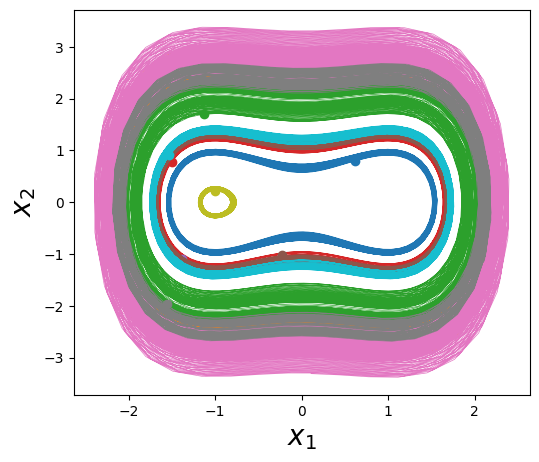

In [23]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(131)
cm = plt.get_cmap("tab10")
print(cm)
for i in range(10):
    ax.plot(Xt[i,0,:], Xt[i,1,:],lw=0.5, color=cm(i))
    ax.plot(Xt[i,0,0], Xt[i,1,0],'o',lw=1.5, color=cm(i)) #initial condition
ax.set_xlabel('$x_1$', fontsize = 20)
ax.set_ylabel('$x_2$', fontsize = 20)
plt.show()

## The Koopman operator
### Discontinuous in time case
Given the discrete non-linear dynamical system

$$
x_{t+1} = \mathbf{F}(x_t)
$$

where $\mathbf{F}$ might be the flow map of the continuous dynamical system in eq (1) and $X = \{x_t | t = 1 \ldots N \}$ the time series of the system state.

$$
\mathbf{F}(x(t_0)) = x(t_0) + \int_{t_0}^{t_0+ t} f(x(\tau))d\tau
$$

the Koopman theory states that there exists an infinite-dimensional linear operator $\mathcal{K}$ that advances in time all observable functions $g_i: \mathbb{R}^n \rightarrow \mathbb{R}$

$$
\mathcal{K} g_i(x) = g_i \circ \mathbf{F}(x).
$$

This way, the non-linear dynamics of $x$, described by $\mathbf{F}$, can be turned into a **linear** dynamical system, described by $\mathcal{K}$, acting on another representation space, formed by the observable quantities $g_i(x)$.

It is then sufficient to find a function $g: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $m \gg n$ that embeds the state $x$ into a "larger enough" dimensional space $m$ such that the linear operator $\mathcal{K}$ can be inferred by a matrix $\mathbf{K} \in \mathbb{R}^{m \times m}$.

To project back the dynamics from the Koopman space ($\mathbb{R}^m$, where $g(x)$ lives) to the phase space ($\mathbb{R}^n$, where $x$ lives), a supplementary function $\varphi: \mathbb{R}^m \rightarrow \mathbb{R}^n$ is needed. Going from $x$ to the Koopman space and back yields $\varphi \text{ o  } g = $ Id.

Under this condition, the functions $g$, $\varphi$ and $\mathbf{K}$ can be parametrized $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{K}_{\phi}$, and the parameters $\theta$, $\rho$ and $\phi$ can be learned minimizing suitable loss functions.

For this purpose, given a time series $X = \{x_t | t = 1 \ldots N \}$, the following conditions hold:


1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x_t)) - x_t  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{K_{\phi}} g_{\theta} ( x_t ) - g_{\theta} (x_{t+1})  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{K_{\phi}} g_{\theta} ( x_t )\right) - x_{t+1} \Vert = 0
     $$

The last three errors can be used as loss functions to train three different neural networks. These different neural networks compose our architecture that can be summarized as in the following sketch:



![architecture](./architecture.png)

In [24]:
# arrange the dataset
from sklearn.model_selection import train_test_split
X = np.transpose(np.concatenate([Xt[i,:,:-1] for i in range(Xt.shape[0])], axis=1))
Y = np.transpose(np.concatenate([Xt[i,:,1:] for i in range(Xt.shape[0])], axis=1))

X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.2)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [25]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.utils.data import DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')

batch_size = 2000     # data per batch

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER)
output_dim = 30       # dimension in Koopman space

In [26]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)


In [27]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [28]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Koopman operator $\mathbf{K}$ (which is linear, and thus a matrix) must have a spectral radius $\rho(\mathbf{K})\le 1$. Such condition will provide a stable -or at least a marginally stable- Koopman operator. To fulfill this requirement, we might leverage on the Perron-Frobenius theorem.

The Perron-Frobenius th. states: if $\mathbf{K}$ is a $m \times m$ positive matrix i.e. $k_{ij} > 0$ for $1 \le i,j \le m$, then the following inequality holds:

$$
\min_i \sum_j k_{ij} \le \rho(\mathbf{K}) \le \max_i \sum_j k_{ij}
$$


**Question 1.** : Complete the `KoopmanModule` class to enforce $\rho(\mathbf{K})\le 1$, making use of the Perron-Frobenius theorem.

In [29]:
class KoopmanModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight = torch.nn.Parameter(torch.randn(output_dim, output_dim))
        ## To Be Implemented
        pf_coeffs = self.weight.sum(axis=1)
        self.weight.data /= max(pf_coeffs.max(),-pf_coeffs.min())
        #self.register_parameter('weights',torch.nn.Parameter(self.weight))

    def forward(self, X):
        x, y = X.shape
        if y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        return torch.matmul(X,self.weight.t())

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [31]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
KPM = KoopmanModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


In [32]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001)
opt_kpm = torch.optim.Adam(KPM.parameters(), lr=0.00001)

**Question 2.** : Define a function to compute the loss to be minimized. It should at least include the 3 terms listed above:
- Reconstruction error
- Prediction error in the Koopman space
- Prediction error in the phase space

Because the different objectives outlined by these losses may compete, the training can be difficult. You may try different variations on these losses and comment your findings. In order to improve the training process, one can for instance:
- Add a multiplicative factor in front of each loss component, to balance their importance;
- We can refine the loss acting upon the latent space, by using a variational autoencoder approach. This is similar to the Gaussian likelihood used in the first practical (TD1). We want the prediction in the latent space (i.e. the Koopman space) to be a normal distribution $\mathcal{N}(0, 1)$ . Add a corresponding loss for the latent space. Difference to 0 mean and 1 standard deviation must be thus included in the loss;
- Freeze the gradients of one part of the network, for instance the encoder, for one specific objective, using the [`requires_grad`](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad_.html) property. For instance:
```python
criterion = nn.MSELoss()
...
# Compute one part loss_l of the total loss
# First deactivate gradient computation for irrelevant parts of the architecture
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = False
loss_l = criterion(pred, target)
# Restore the gradient computation
for p in AUTOENCODER.encoder.parameters():
    p.requires_grad = True
...
total_loss = loss_1 + ... + loss_l + ...
return total_loss
```

In [33]:
def LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred,recon_coeff=1,koopman_coeff=1,phase_coeff=2):
    criterion = nn.MSELoss()

    #Reconstruction term
    recon_loss = criterion(X_recon,X_)

    #Prediction Koopman
    for p in AUTOENCODER.encoder.parameters():
        p.requires_grad = False
    koopman_loss = criterion(gY_pred,gY_)
    for p in AUTOENCODER.encoder.parameters():
        p.requires_grad = True

    #Prediction phase
    phase_loss = criterion(Y_pred,Y_)

    #Total loss
    total_loss = (recon_coeff*recon_loss + koopman_coeff*koopman_loss + phase_coeff*phase_loss).mean()

    return total_loss

The following cell executes the training loop. You can modify it in order to display the different intermediate losses computed in the function `LOSS` above.

In [ ]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001, weight_decay=1e-3)
opt_lie = torch.optim.Adam(LIE.parameters(), lr=0.00001, weight_decay=1e-3)

In [34]:
for epoch in range(100):
    AUTOENCODER.train()
    KPM.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for X_, Y_ in train_dataloader:
        X_, Y_ = X_.to(device), Y_.to(device)

        opt_aut.zero_grad()
        opt_kpm.zero_grad()


        # gX_ = observable(X_), gY_ = observable(Y_)
        gX_ = AUTOENCODER.encoder(X_)
        gY_ = AUTOENCODER.encoder(Y_)

        # X_recon = in_observable(observable(X_))
        X_recon = AUTOENCODER.decoder(gX_)

        # gY_pred = KPM*observable(X_)
        gY_pred = KPM(gX_)

        # Y_pred = inv_observable(KPM*observable(X_))
        Y_pred = AUTOENCODER.decoder(gY_pred)

        output = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
        output.backward()
        opt_aut.step()
        opt_kpm.step()

        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)

    if epoch%1 == 0:
        print(epoch, total_train_loss)

    if epoch%10 == 0:
        AUTOENCODER.eval()
        KPM.eval()
        with torch.no_grad():
            total_test_loss = 0
            for X_, Y_ in test_dataloader:
                X_, Y_ = X_.to(device), Y_.to(device)

                gX_ = AUTOENCODER.encoder(X_)
                gY_ = AUTOENCODER.encoder(Y_)
                X_recon = AUTOENCODER.decoder(gY_)
                gY_pred = KPM(gX_)
                Y_pred = AUTOENCODER.decoder(gY_pred)

                output = LOSS(X_, Y_, X_recon, gX_, gY_, gY_pred, Y_pred)
            total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print('-'*106)


0 0.002696969299722898
-------------------------------------------------- TEST --------------------------------------------------
0 9.11359903977867e-05
----------------------------------------------------------------------------------------------------------
1 0.002507098612366222
2 0.0017562859735282125
3 0.00143757896292941
4 0.0012932503191828697
5 0.0011855416986411844
6 0.0011120735008277242
7 0.0010619965906810524
8 0.0010175452283519618
9 0.0009724617143659894
10 0.000926807207860319
-------------------------------------------------- TEST --------------------------------------------------
10 3.0078895967149487e-05
----------------------------------------------------------------------------------------------------------
11 0.0008686497128000816
12 0.0006926138638143447
13 0.0003322741066836333
14 0.00020038935666231064
15 0.00014771754004336016
16 0.0001122263245128925
17 8.729516571871403e-05
18 7.051107002669854e-05
19 5.824300495466884e-05
20 4.85971017199077e-05
------------

#### Verification

**Question 3.** : We want to ensure the Koopman operator is stable. This can be verified by checking whether its spectral radius $\rho(\mathbf{K})\le 1$. Plot the eigenvalues of the Koopman operator in order to verify the bound on its spectral radius. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

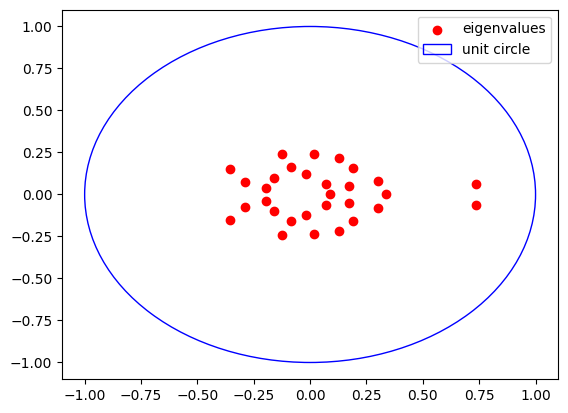

In [35]:
# To be completed
#check Koopman stability
# Plot the eigen values of the Koopman operator against the unit circle
eigval,_ = np.linalg.eig(KPM.weight.cpu().detach().numpy())

fig,ax = plt.subplots()

plt.scatter(np.real(eigval),np.imag(eigval),color='red',label='eigenvalues')
circle =plt.Circle((0,0),1,color='blue',fill=False,label='unit circle')
ax.add_patch(circle)

plt.legend()

plt.show()

In [36]:
N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = duffing(0,np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval()
KPM.eval()
Flow_pred = np.zeros((N,N,2))
Koop = KPM #added
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] = (AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), Koop.weight.t())
                            ).detach().cpu().numpy() - [[xv[i,j],yv[i,j]]]).ravel()/(tmax/niter)


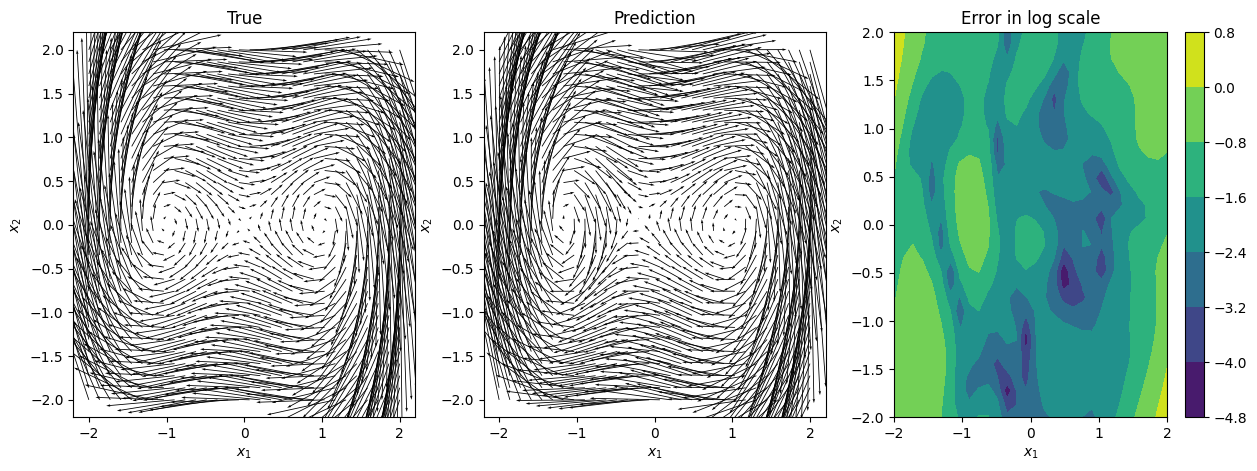

In [37]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

### Continuous in time case

Considering $x_r$ as the observation of a state at time $t$, and $x_{r+1}$ the state at time $t+ \Delta t$, for $\Delta t \rightarrow 0$  it is also possible to define the continuous-time infinitesimal generator of the Koopman operator family as

$$
\mathcal{L} g (x_t)  = \lim_{\Delta t \rightarrow 0} \frac{\mathcal{K}g(x_t)- g(x_{t})}{\Delta t} = \frac{g \circ\mathbf{F} (x_t) -x_t}{\Delta t}
$$

The pevious expression defines the Lie derivative, and for this reason $\mathcal{L}$ is known as the Lie operator. $\mathcal{L}$ describes the continuous dynamics of the observables in the Koopman space:

$$
\dot{g} (x) = \mathcal{L} g(x).
$$

The latter can be further expressed as:

$$
\dot{g} (x(t)) = \frac{dg(x)}{dt} = \nabla_x g \frac{dx}{dt} = \nabla_x g \cdot f(x) =\mathcal{L} g(x).
$$

Given $g_{\theta}$, $\varphi_{\rho}$ and $\mathbf{L}_{\phi}$ three parameterized functions, the following conditions hold:

1.   Reconstruction error
     $$
     \Vert \varphi_\rho (g_\theta(x)) - x  \Vert = 0
     $$
2.   Prediction error in Koopman space
     $$
     \Vert \mathbf{L_{\phi}} g_{\theta} ( x ) - \nabla g_{\theta} \cdot f(x)  \Vert = 0
     $$
3.   Prediction error in the phase space
     $$
     \Vert \varphi_{\rho} \left( \mathbf{L_{\phi}} g_{\theta} ( x )\right) - f(x) \Vert = 0
     $$

As long as the system $f(x)$ is known, the three errors can be computed without data belonging to trajectories.

In [38]:
# create dataset for continuous Koopman
# with the same amount of points of the Discontinuous Koopman case
X0 = (np.random.rand(Ninit*(niter-1),2)-0.5)*4
dX =np.zeros(X0.shape)
for i in tqdm(range(X0.shape[0])):
    dX[i,:] = duffing(0,X0[i,:])

100%|██████████| 299940/299940 [00:00<00:00, 417569.89it/s]


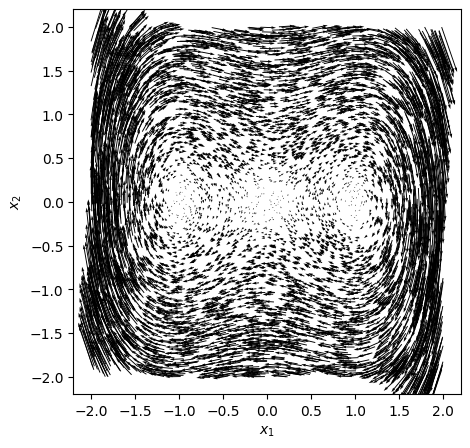

In [39]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.quiver(X0[::50,0],X0[::50,1], dX[::50,0]*0.2, dX[::50,1]*0.2, scale=10)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [40]:
# create the models
feature_dim = 2       # dimension of the Duffing oscillator
hidden_layer = 5      # number of hidden layers in g (ENCODER) and \varphi (DECODER)
output_dim = 30       # dimension in Koopman space
batch_size = 2000     # data per batch

In [41]:
X_train, X_test, Y_train, Y_test =  train_test_split(X0, dX, test_size=0.2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

training_data = TensorDataset(torch.from_numpy(X_train),torch.from_numpy(Y_train))
test_data = TensorDataset(torch.from_numpy(X_test),torch.from_numpy(Y_test))

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

(239952, 2) (59988, 2) (239952, 2) (59988, 2)


In [42]:
class encoder(nn.Module):
    def __init__(self, layer_dim):
        super(encoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i+1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [43]:
class decoder(nn.Module):
    def __init__(self, layer_dim):
        super(decoder, self).__init__()
        self.layer_dim = layer_dim
        self.list_FC = nn.ModuleList()
        for i in range(len(self.layer_dim)-1,0,-1):
            self.list_FC.append(nn.Linear(self.layer_dim[i], self.layer_dim[i-1]))

    def forward(self, X):
        for i in range(len(self.layer_dim)-2):
            X = F.elu(self.list_FC[i](X))
        return self.list_FC[-1](X)

In [44]:
class autoencoder(nn.Module):
    def __init__(self,feature_dim, hidden_layer, output_dim):
        super(autoencoder, self).__init__()
        layer_dim = [output_dim if i == hidden_layer else feature_dim+i*(output_dim-feature_dim)//hidden_layer for i in range(hidden_layer+1)]
        self.encoder = encoder(layer_dim)
        self.decoder = decoder(layer_dim)
    def forward(self, X):
        X = self.encoder(X)
        return self.decoder(X)

The Lie operator must be defined such that it will be always stable by construction.
To do that, we consider a matrix of parameters $\Psi \in \mathbb{R}^{m \times m}$ and a vector of parameters $\Gamma \in \mathbb{R}^m$. The resulting Lie operator will be of the form:

$$
\mathbf{L} = (\Psi - \Psi^T) - \text{diag}(\vert \Gamma \vert)
$$

with eigenvalues whose real part $\Re(\lambda) \leq 0$ .
See https://math.stackexchange.com/questions/952233/eigenvalues-of-the-sum-of-a-diagonal-matrix-and-a-skew-symmetric-matrix for the mathematical proof. Moreover if $\lambda \in \mathbb{C}$ is an eigenvalue of $\mathbf{L}$, it turns out that its real part $\Re(\lambda) \propto \Vert \Gamma \Vert$, i.e. it only depends on $\Gamma$. Minimizing the $\Vert \cdot \Vert_{\infty}$ norm, we can force just a few modes to be on the $\Re(\lambda) =0$ axes.



**Question 4.** : As you did for the discrete case, you now have to implement the `LieModule` module. It should have the form indicated above to guarantee $\Re(\lambda) \leq 0$.

In [45]:
# custom nn.Linear to recover the Lie operator
class LieModule(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        self.output_dim = output_dim
        self.weight = torch.nn.Parameter(torch.randn(output_dim, output_dim))
        self.diagonal = torch.nn.Parameter(-torch.abs(torch.randn(output_dim)))# To be Implemented
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))

    def forward(self, X):
        x, y = X.shape
        if x != self.output_dim and y != self.output_dim:
            sys.exit(f'Wrong Input Features. Please use tensor with {self.output_dim} Input Features')
        L = self.weight - self.weight.t() - torch.diag(self.diagonal)
        return torch.matmul(X,L.t()) , L

In [46]:
# start training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [47]:
AUTOENCODER = autoencoder(feature_dim, hidden_layer, output_dim).to(device)
LIE = LieModule(output_dim).to(device)
print(AUTOENCODER)

autoencoder(
  (encoder): encoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=2, out_features=7, bias=True)
      (1): Linear(in_features=7, out_features=13, bias=True)
      (2): Linear(in_features=13, out_features=18, bias=True)
      (3): Linear(in_features=18, out_features=24, bias=True)
      (4): Linear(in_features=24, out_features=30, bias=True)
    )
  )
  (decoder): decoder(
    (list_FC): ModuleList(
      (0): Linear(in_features=30, out_features=24, bias=True)
      (1): Linear(in_features=24, out_features=18, bias=True)
      (2): Linear(in_features=18, out_features=13, bias=True)
      (3): Linear(in_features=13, out_features=7, bias=True)
      (4): Linear(in_features=7, out_features=2, bias=True)
    )
  )
)


Some tricks are needed to train. If the autoencoder and the Lie model are learned at the same speed, the training turns out to be highly unstable since the three loss functions have moving targets. For this reason, the Lie learning rate has been chosen smaller than the autoencoder one.

In [48]:
opt_aut = torch.optim.Adam(AUTOENCODER.parameters(), lr=0.0001, weight_decay=1e-3)
opt_lie = torch.optim.Adam(LIE.parameters(), lr=0.00001, weight_decay=1e-3)

A further loss is considered to stabilize the learning stage. The state $x$ belongs to a compact set, since it is the solution of a dissipative dynamical system. This is not true for $g(x)$ (we need to choose appropriate activation functions to have appropriate Liptchitz guarantees). To avoid discrepancies in magnitudes of $g_i(x)$, a regularization loss is added:

$$
\mu = \frac{1}{m} \sum_m g_i(x) = 0  \quad \text{and} \quad  \sigma = \left( \frac{1}{m}\sum_m(g_i(x)-\mu)^2 \right)^{1/2} = 1
$$

inspired by VAE.

For the training to be smooth, the encoder parameters are not affected by the **prediction loss in phase space**. This is based on an empirical observation and is motivated by the fact that the encoder appears in the three losses and plays a competitive role against the decoder and the Lie model. This should not affect the results since the encoder remains coupled with the decoder in the **reconstruction loss** and with the Lie operator in the **prediction loss in Koopman space**.

**Question 5.** : Implement the loss function similarly to what you did for the **Question 2.**

In [49]:
def LOSS(X_, dX, gX, dgX, X_recon, dX_recon, jvp,recon_coeff=1,koopman_coeff=1,phase_coeff=1):
    criterion = nn.MSELoss()

    #Reconstruction term
    recon_loss = criterion(X_recon,X_)

    #Prediction Koopman
    koopman_loss = criterion(dgX,jvp)

    #Prediction phase
    phase_loss = criterion(dX_recon,dX)

    #Total loss
    total_loss = (recon_coeff*recon_loss + koopman_coeff*koopman_loss + phase_coeff*phase_loss).mean()

    # To be Implemented
    return total_loss

Since trajectories are not needed, random states can be sampled from the system manifold $x_1 \in [-2, 2]$, $x_2 \in [-2, 2]$ (see previous figure).

In [50]:
for epoch in range(100):
    AUTOENCODER.train()
    LIE.train()
    total_train_loss = 0
    total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
    for X_, dX_ in train_dataloader:
        X_, dX_ = X_.to(device), dX_.to(device)

        opt_aut.zero_grad()
        opt_lie.zero_grad()

        # dgX = LIE*gX
        # jvp = \nabla g * f(X_)
        (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
        X_recon = AUTOENCODER.decoder(gX)

        dgX, L = LIE(gX)
        dX_recon = AUTOENCODER.decoder(dgX)

        output = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
        output.backward()
        opt_aut.step()
        opt_lie.step()

        if epoch%1 == 0:
            total_train_loss += output.item()/X_.size(0)/len(train_dataloader)
    if epoch%1 == 0:

        print(epoch, total_train_loss)

    if epoch%10 == 0:
        AUTOENCODER.eval()
        LIE.eval()
        with torch.no_grad():
            total_test_loss = 0
            total_loss1, total_loss2, total_loss3, total_loss4 = 0, 0, 0, 0
            for X_, dX_ in test_dataloader:
                X_, dX_ = X_.to(device), dX_.to(device)

                (gX, jvp) = autograd.functional.jvp(AUTOENCODER.encoder,X_,dX_, create_graph=True)
                X_recon = AUTOENCODER.decoder(gX)

                dgX, L = LIE(gX)
                dX_recon = AUTOENCODER.decoder(dgX)

                output = LOSS(X_, dX_, gX, dgX, X_recon, dX_recon, jvp)
                total_test_loss += output.item()/X_.size(0)/len(test_dataloader)
            print('-'*50, 'TEST', '-'*50)
            print(epoch, total_test_loss)
            print('-'*106)


0 0.002042839729846494
-------------------------------------------------- TEST --------------------------------------------------
0 0.0020184990451714837
----------------------------------------------------------------------------------------------------------
1 0.001961155126768555
2 0.0015855467071736325
3 0.0011938941034595513
4 0.0009553158611448136
5 0.0007742169023747999
6 0.0006557986857878892
7 0.0005857924870009478
8 0.0005381002838279104
9 0.0004977170019117812
10 0.0004471110221659225
-------------------------------------------------- TEST --------------------------------------------------
10 0.0004064520094780247
----------------------------------------------------------------------------------------------------------
11 0.00032928848680516726
12 0.00019324567062547164
13 0.00014975130669311545
14 0.00012374432970805883
15 0.00010404286253286524
16 8.879394092611066e-05
17 7.65192600354116e-05
18 6.65754961786389e-05
19 5.8398463140666205e-05
20 5.146170829260929e-05
------

### Verification

**Question 6.** : As in the **Question 3.** we want to ensure the Lie operator is stable. This can be verified by checking that the real part of the eigenvalues is negative. Plot the relevant eigenvalues of the Lie operator. You can use the [`numpy.linalg.eig`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) function to retrieve the eigenvalues of a matrix.

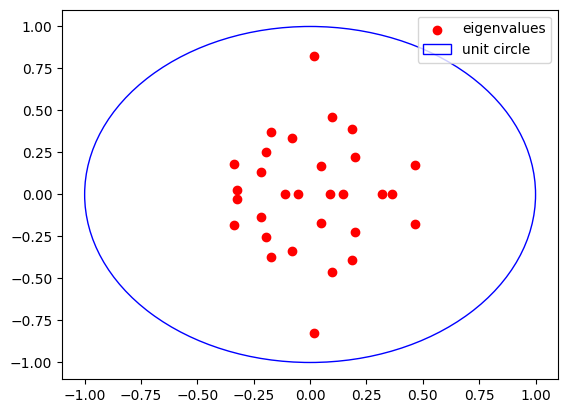

In [51]:
#check LIE stability
# To Be Implemented
eigval,_ = np.linalg.eig(LIE.weight.cpu().detach().numpy())

fig,ax = plt.subplots()

plt.scatter(np.real(eigval),np.imag(eigval),color='red',label='eigenvalues')
circle =plt.Circle((0,0),1,color='blue',fill=False,label='unit circle')
ax.add_patch(circle)

plt.legend()

plt.show()

In [52]:
def DUFFING(x : np.ndarray) -> np.ndarray:
    dx = np.zeros(x.shape)
    dx[0] = x[1]
    dx[1] = x[0] -x[0]**3
    return dx

N = 30
x = np.linspace(-2, 2, N)
y = np.linspace(-2, 2, N)
xv, yv = np.meshgrid(x, y)

Flow = np.zeros((N,N,2))

for i in range(N):
    for j in range(N):
        Flow[i,j,:] = DUFFING(np.array([xv[i,j],yv[i,j]]))

AUTOENCODER.eval()
LIE.eval()
Flow_pred = np.zeros((N,N,2))
for i in range(N):
    for j in range(N):
        Flow_pred[i,j,:] =  AUTOENCODER.decoder(
                            torch.matmul(
                            AUTOENCODER.encoder(torch.from_numpy(np.array([[xv[i,j],yv[i,j]]])).to(device)), L.t())
                            ).detach().cpu().numpy()


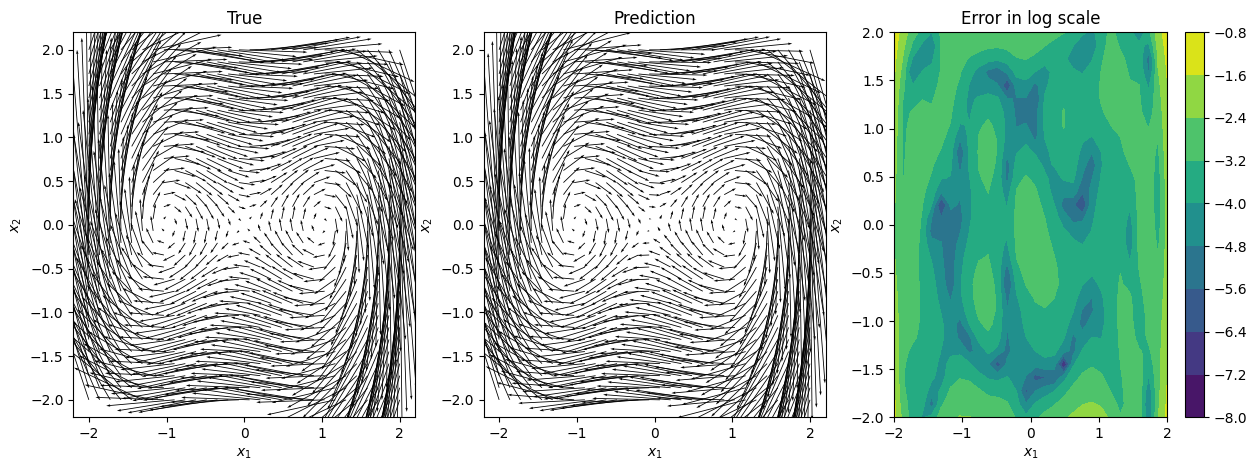

In [53]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax.quiver(xv,yv, Flow[:,:,0], Flow[:,:,1], scale=10)
ax.set_title('True')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(132)
ax.quiver(xv,yv, Flow_pred[:,:,0], Flow_pred[:,:,1], scale=10)
ax.set_title('Prediction')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

ax = fig.add_subplot(133)
cp = ax.contourf(xv, yv, np.log(np.linalg.norm(Flow - Flow_pred, axis=2)))
fig.colorbar(cp)
ax.set_title('Error in log scale')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()